##Dataset download

In [1]:
!gdown --folder 1F1xGF0sPXaGn4kFuoG_v8ZeiLd7NIcvA

Retrieving folder contents
Processing file 1hel_NdeNP00joy8K44jQVIbIkegyByRB Adani Enterprises.csv
Processing file 1un3LrZFeeLQ1U4I_1r5dthbr7o2NiMYC Adani Ports & SEZ.csv
Processing file 1EAMJ23g_wYqCP2-PSUaJvE7BwIJQf0z8 Adani Power.csv
Processing file 17own6QWyvC7TTPpqRqQkPXyfUg9eIWtk Axis Bank.csv
Processing file 1mSIEdNqz18m6HBRr1SMzZKxrjhX7E51b DLF.csv
Processing file 1KPH5wQkM-lt_v63Iqt0H1Cl7E8tXcDRj Hindalco Industries.csv
Processing file 1PLRqN2fSHVuJxweuHK03PS1zhZJ3pR0O ICICI Bank.csv
Processing file 11ZePFEIWIG9row9xUBbMTk_X29MhqQ65 Larsen & Toubro.csv
Processing file 1MpYKU_laAcoVOUXaeppeZ8ZB4NUWDLg_ Power Finance Corporation.csv
Processing file 1akOYhgldgiw_lNoRKRfnv3n0oQavlj0e Punjab National Bank.csv
Processing file 1i3nT97qqD_COA2AM2NcAleTxdYyH94wf Rural Electrification Corporation.csv
Processing file 1YDMYM74YJzOR91sD2Ww84AWM0JM4Xz9X State Bank of India.csv
Processing file 1_OSTnc_wWeQc9_Iq86UF_EBu8GdThmB0 Tata Motors.csv
Processing file 1CRo0BruZ6k1ukVjT2A7R7ysZeoIUPU_6

#Making of the Code(with 80-20 split)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


351/351 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - loss: 0.0161 - val_loss: 0.0030
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 43s 65ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 42s 71ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 42s 65ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 9/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 10/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - loss: 0.0024 - val_loss: 0.0030
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Sharpe Ratio: 11.215911027499978


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


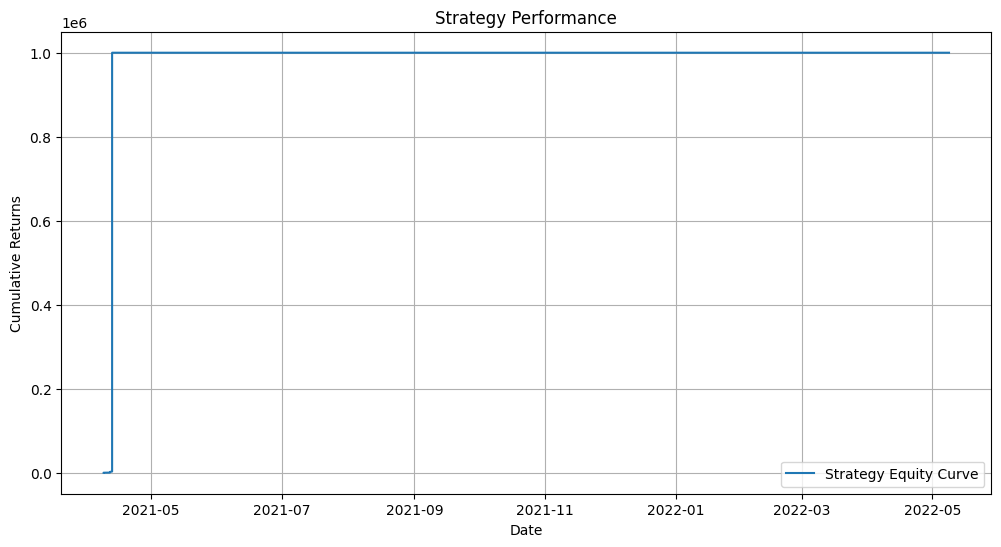

In [33]:
# Import required libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Load and prepare data with additional preprocessing for Volume
def load_and_prepare_data(folder_path):
    dataframes = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            df = pd.read_csv(os.path.join(folder_path, file_name))
            df['Instrument'] = file_name.split('.')[0]  # Add instrument name
            df['Date'] = pd.to_datetime(df['Date'])

            # Remove commas and convert Volume to numeric
            df['Volume'] = df['Volume'].replace({',': ''}, regex=True).astype(float)

            dataframes.append(df)
    combined_data = pd.concat(dataframes, ignore_index=True)
    return combined_data

# Load data
folder_path = '/content/L2'  # Path to your folder
data = load_and_prepare_data(folder_path)

# Sort and preprocess
data = data.sort_values(by=['Date', 'Instrument']).reset_index(drop=True)
features = ['Open', 'High', 'Low', 'Close', '% Change', 'Volume']

# Handle missing values
data = data.dropna(subset=features)

# Scale features
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Generate sequences for LSTM
def create_sequences(data, instruments, sequence_length=60):
    X, y = [], []
    for instrument in instruments:
        instrument_data = data[data['Instrument'] == instrument]
        values = instrument_data[features].values
        for i in range(sequence_length, len(values)):
            X.append(values[i-sequence_length:i, :-1])  # Features
            y.append(values[i, -2])  # Target: '% Change'
    return np.array(X), np.array(y)

sequence_length = 60
instruments = data['Instrument'].unique()
X, y = create_sequences(data, instruments)

# Split into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Predict % Change
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Predict on test data
predicted_changes = model.predict(X_test)

# Backtest the strategy
test_data = data.iloc[-len(y_test):].copy()
test_data['Predicted % Change'] = scaler.inverse_transform(
    np.hstack((np.zeros((len(predicted_changes), len(features) - 1)), predicted_changes))
)[:, -1]

# Define buy/sell signals based on predictions
test_data['Signal'] = np.where(test_data['Predicted % Change'] > 0, 1, -1)
test_data['Strategy Return'] = test_data['Signal'] * test_data['% Change']

# Calculate Sharpe Ratio
risk_free_rate = 0.02  # Example risk-free rate
strategy_return = test_data['Strategy Return']
sharpe_ratio = (strategy_return.mean() - risk_free_rate) / strategy_return.std()

# Output results
print(f"Sharpe Ratio: {sharpe_ratio}")

# Calculate cumulative returns and avoid overflow
test_data['Cumulative Returns'] = (1 + test_data['Strategy Return']).cumprod()

# Clip extreme values to avoid overflow in plotting
test_data['Cumulative Returns'] = np.clip(test_data['Cumulative Returns'], 1e-6, 1e6)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_data['Date'], test_data['Cumulative Returns'], label='Strategy Equity Curve')
plt.title('Strategy Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



#Model Creation

In [29]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load and prepare data with additional preprocessing for Volume
def load_and_prepare_data(folder_path):
    dataframes = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            df = pd.read_csv(os.path.join(folder_path, file_name))
            df['Instrument'] = file_name.split('.')[0]  # Add instrument name
            df['Date'] = pd.to_datetime(df['Date'])

            # Remove commas and convert Volume to numeric
            df['Volume'] = df['Volume'].replace({',': ''}, regex=True).astype(float)

            dataframes.append(df)
    combined_data = pd.concat(dataframes, ignore_index=True)
    return combined_data

# Generate sequences for LSTM
def create_sequences(data, instruments, sequence_length=60):
    X, y = [], []
    features = ['Open', 'High', 'Low', 'Close', '% Change', 'Volume']
    for instrument in instruments:
        instrument_data = data[data['Instrument'] == instrument]
        values = instrument_data[features].values
        for i in range(sequence_length, len(values)):
            X.append(values[i-sequence_length:i, :-1])  # Features
            y.append(values[i, -2])  # Target: '% Change'
    return np.array(X), np.array(y)

# Load and prepare the data
folder_path = '/content/L2'  # Path to your folder
data = load_and_prepare_data(folder_path)

# Sort and preprocess
data = data.sort_values(by=['Date', 'Instrument']).reset_index(drop=True)
features = ['Open', 'High', 'Low', 'Close', '% Change', 'Volume']

# Handle missing values
data = data.dropna(subset=features)

# Scale features
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Generate sequences for LSTM
sequence_length = 60
instruments = data['Instrument'].unique()
X, y = create_sequences(data, instruments)

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Predict % Change
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the entire dataset
model.fit(X, y, batch_size=32, epochs=10)

# Save the complete model for future use
model.save('trained_model.h5')

print("Model trained and saved successfully.")


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


439/439 ━━━━━━━━━━━━━━━━━━━━ 34s 70ms/step - loss: 0.0073
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 45s 78ms/step - loss: 0.0028
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 36s 67ms/step - loss: 0.0027
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - loss: 0.0025
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - loss: 0.0026
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 50s 81ms/step - loss: 0.0026
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 36s 82ms/step - loss: 0.0026
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 42s 84ms/step - loss: 0.0026
Epoch 9/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - loss: 0.0026
Epoch 10/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 33s 62ms/step - loss: 0.0025


Model trained and saved successfully.


#Testing

##Repalce with the testing data folder below for testing the output on specific dataset

In [ ]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load and prepare data with additional preprocessing for Volume
def load_and_prepare_data(folder_path):
    dataframes = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            df = pd.read_csv(os.path.join(folder_path, file_name))
            df['Instrument'] = file_name.split('.')[0]  # Add instrument name
            df['Date'] = pd.to_datetime(df['Date'])

            # Remove commas and convert Volume to numeric
            df['Volume'] = df['Volume'].replace({',': ''}, regex=True).astype(float)

            dataframes.append(df)
    combined_data = pd.concat(dataframes, ignore_index=True)
    return combined_data

# Generate sequences for LSTM
def create_sequences(data, instruments, sequence_length=60):
    X, y = [], []
    features = ['Open', 'High', 'Low', 'Close', '% Change', 'Volume']
    for instrument in instruments:
        instrument_data = data[data['Instrument'] == instrument]
        values = instrument_data[features].values
        for i in range(sequence_length, len(values)):
            X.append(values[i-sequence_length:i, :-1])  # Features
            y.append(values[i, -2])  # Target: '% Change'
    return np.array(X), np.array(y)

# Load the saved model
model = load_model('trained_model.h5')

# Load and prepare the test data (from folder L3)
folder_path = '/content/L3'  # Path to your new folder with test data
data = load_and_prepare_data(folder_path)

# Sort and preprocess
data = data.sort_values(by=['Date', 'Instrument']).reset_index(drop=True)
features = ['Open', 'High', 'Low', 'Close', '% Change', 'Volume']

# Handle missing values
data = data.dropna(subset=features)

# Scale features (use the same scaler fitted on training data)
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Generate sequences for LSTM
sequence_length = 60
instruments = data['Instrument'].unique()
X, y = create_sequences(data, instruments)

# Make predictions on the test data
predicted_changes = model.predict(X)

# Backtest the strategy
test_data = data.iloc[-len(y):].copy()
test_data['Predicted % Change'] = scaler.inverse_transform(
    np.hstack((np.zeros((len(predicted_changes), len(features) - 1)), predicted_changes))
)[:, -1]

# Define buy/sell signals based on predictions
test_data['Signal'] = np.where(test_data['Predicted % Change'] > 0, 1, -1)
test_data['Strategy Return'] = test_data['Signal'] * test_data['% Change']

# Calculate Sharpe Ratio
risk_free_rate = 0.02  # Example risk-free rate
strategy_return = test_data['Strategy Return']
sharpe_ratio = (strategy_return.mean() - risk_free_rate) / strategy_return.std()

# Output results
print(f"Sharpe Ratio: {sharpe_ratio}")

# Calculate cumulative returns and avoid overflow
test_data['Cumulative Returns'] = (1 + test_data['Strategy Return']).cumprod()

# Clip extreme values to avoid overflow in plotting
test_data['Cumulative Returns'] = np.clip(test_data['Cumulative Returns'], 1e-6, 1e6)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_data['Date'], test_data['Cumulative Returns'], label='Strategy Equity Curve')
plt.title('Strategy Performance on Test Data')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()
